## Visualizing the Bexar Data

To better understand potential features for future models, I visualized several of the variables. I started by plotting the criminally-linked properties on a map to determine if there was any geographic affiliation. I then visualized the differences between types of ownership. Next, I compared price per square foot across ownership types, foreign ownership, and owners who own multiple properties, among other variables. I then compared YoY price fluctuations between criminally-linked properties and the broader population of data. Lastly, I dropped several variables and plotted correlation.

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import json

sns.set_style('darkgrid')

import folium
from folium.plugins import HeatMap
from folium import plugins
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from scipy import stats

In [4]:
# Load in data
prop_df = pd.read_hdf('../data/processed/bexar_processed.h5')

### Plot Properties on Map

In [5]:
# Pull out addresses and zip codes for criminally-linked properties
mapping_crim_df = prop_df[prop_df['crim_address'].notna()==True][['crim_address','property_zip']].reset_index()

In [6]:
geolocator = Nominatim(user_agent="property_mapping_project")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=4)

skip = 1
if skip == 0:
    x = mapping_crim_df['crim_address'].tolist()
    names = []

    for item in x:
        d={}
        a = geocode(item, exactly_one=True, timeout=60)
        try:
            d["Latitude"] = a.latitude
        except:
            pass
        try:
            d["Longitude"] = a.longitude
        except:
            pass
    #     time.sleep(2)
        names.append(d)
        
    mapping_crim_df['coord'] = names

In [7]:
# Now grab the blank coordinates with zip codes
skip = 1
if skip == 0:
    y = mapping_crim_df[mapping_crim_df.coord == {}].property_zip.unique().tolist()
    zip_coords = []

    for item in y:
        d = {}
        a = geocode(item, exactly_one=True, timeout=60)
        try:
            d["Latitude"] = a.latitude
        except:
            pass
        try:
            d["Longitude"] = a.longitude
        except:
            pass
        zip_coords.append(d)
        
    zip_coords_dict = {}
    for i, j in enumerate(y):
        print(zip_coords[i],j)
        zip_coords_dict[j] = zip_coords[i]
        
    # Map onto coord column
    mask = mapping_crim_df[mapping_crim_df.coord=={}].index
    mapping_crim_df.loc[mask,'coord'] = mapping_crim_df.iloc[mask].property_zip.map(zip_coords_dict)

    # Pull out data for mapping
    data = [[row['coord']['Latitude'],row['coord']['Longitude'],row['crim_address']] for index, row in mapping_crim_df.iterrows()]

In [8]:
# Seems some of the coordinates are quite a bit off
# Ignoring those

In [9]:
skip = 1
if skip == 0:
    # Use folium to map each point
    m = folium.Map(
        location=[29.513151, -98.497901],
        zoom_start=9
    )

    for i in data:
        folium.Marker(
            i[:2],
            popup=i[2],
            icon=folium.Icon(color='red',icon='map-marker',prefix='fa')
        ).add_to(m)

    display(m)
    
    # Save as html
#     m.save("crim_prop_map.html")

The above map seems to indicate that these properties are geographically concentrated.

### Distribution of Year Built for Criminally-Linked Properties

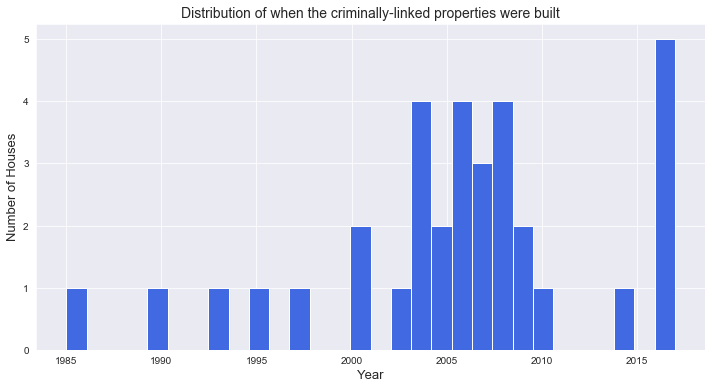

In [36]:
plt.figure(figsize=(12,6))
plt.title('Distribution of when the criminally-linked properties were built',fontsize=14)
prop_df[(prop_df.crim_prop==1) & (prop_df['Yr_blt']>0)]['Yr_blt'].plot(kind='hist',bins=30,color='royalblue')
plt.ylabel('Number of Houses',fontsize=13)
plt.xlabel('Year',fontsize=13)
plt.show()

Most are recently-built houses.

### Different Ownership Types Across Labels

In [87]:
def plot_ownership_breakdown(title,dataframe,binary_column,):
    crim_sub_df = dataframe[dataframe.crim_prop==1]
    
    fig, axes = plt.subplots(1,2,figsize=[15,5])
    fig.suptitle(title,fontsize=14)

    crim_counts_df = crim_sub_df[binary_column].value_counts().sort_index()
    crim_counts_df.index = ['Not a company','Company']
    color = plt.cm.Pastel1(np.arange(len(crim_counts_df)))

    # Criminially-associated properties
    crim_counts_df.plot.bar(
        rot=0,ax=axes[0],
        title="Criminal Properties",
        color=color
    )
    axes[0].set_ylabel('Number of properties',labelpad=10)

    # Broader population (ex criminal properties)
    broad_counts_df = dataframe[dataframe.crim_prop!=1][binary_column].value_counts().sort_index()
    broad_counts_df.index = ['Not a company','Company']
    broad_counts_df.plot.bar(
        rot=0,ax=axes[1],
        title="Broader Population (ex criminal properties)",
        color=color
    )

    plt.show()

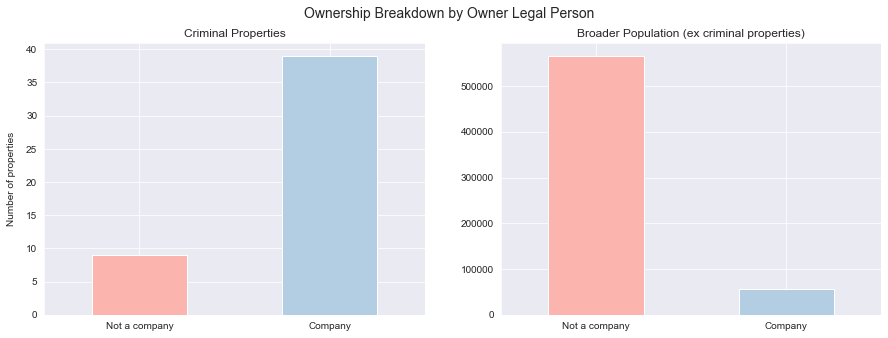

In [75]:
plot_ownership_breakdown(
    title="Ownership Breakdown by Owner Legal Person",
    dataframe=prop_df,
    binary_column='owner_legal_person'
)

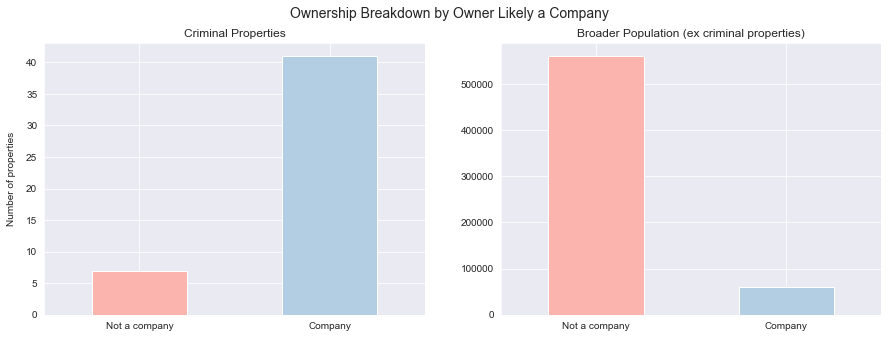

In [76]:
plot_ownership_breakdown(
    title="Ownership Breakdown by Owner Likely a Company",
    dataframe=prop_df,
    binary_column='owner_likely_company'
)

The broader population of residential properties are far more often owned by a natural person than a company. The opposite is true for those properties labeled as criminally-linked, matching a common typology for money-laundering in real property.

### Price PSF Across Different Ownership Types

In [85]:
groups = ['owner_legal_person','owner_likely_company','owner_is_trust']

def group_stats(groups,dataframe):
    for group in groups:
        print(dataframe.groupby(group)['price_psf'].agg(['median','mean','min','max']),'\n')
        
group_stats(groups,prop_df)

                        median        mean       min            max
owner_legal_person                                                 
0                   101.126372  105.582039  0.086096   23736.939394
1                    94.689737  167.625694  0.019408  124520.000000 

                          median        mean       min            max
owner_likely_company                                                 
0                     101.050735  106.945432  0.059292   27574.166667
1                      97.287757  148.809171  0.019408  124520.000000 

                    median        mean       min            max
owner_is_trust                                                 
0               100.748830  109.568537  0.019408  124520.000000
1               108.233618  122.071230  6.230264    9331.186306 



In [97]:
def plot_price_by_owner(groups,dataframe,title):
    fig, axes = plt.subplots(nrows=1,ncols=len(groups),figsize=[15,8])

    for ax, var in zip(axes.flat,groups):
        dataframe[['price_psf',var]].boxplot(by=[var], ax=ax)
        ax.set_xlabel(var,fontsize=15)
        ax.set_title('')
        
    axes[0].set_ylabel('Price per square foot',labelpad=10,fontsize=15)
    fig.suptitle(title,fontsize=15)
    plt.show()

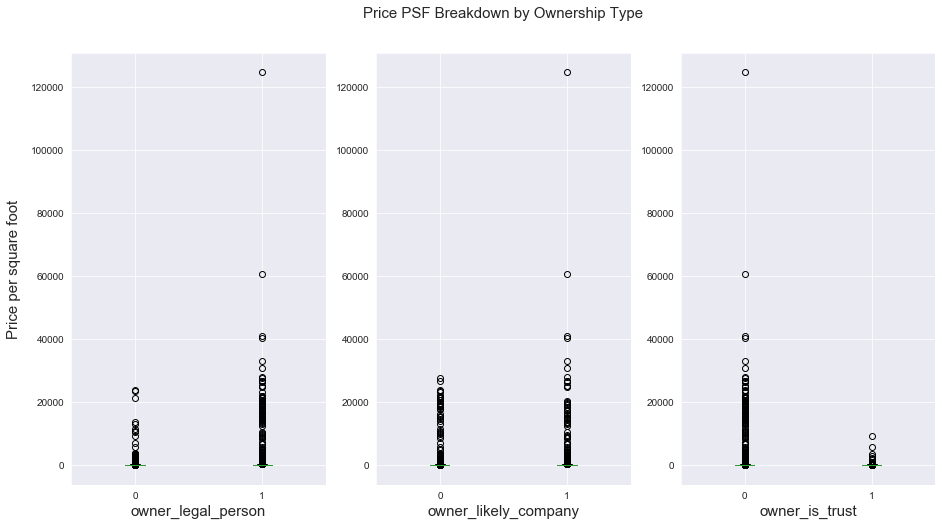

In [98]:
plot_price_by_owner(
    groups=groups,
    dataframe=prop_df,
    title='Price PSF Breakdown by Ownership Type'
)

In [55]:
# Investigate some of these outlier properties
prop_df[prop_df.price_psf==prop_df.price_psf.max()][[
    'situs_num',
    'situs_street_prefx',
    'situs_street',
    'situs_city',
    'land_acres',
    'Sq_ft'
]]

,situs_num,situs_street_prefx,situs_street,situs_city,land_acres,Sq_ft
290945,542,NaN,CITRUS RD,SAN ANTONIO,0,1


It seems in this case that for some reason the square footage is listed as 1. The property appears to be an industrial park, so it could be encoded incorrectly as a residential property.

In [18]:
# Inspecting more
print(prop_df[prop_df.price_psf>=prop_df.price_psf.quantile(.999)][[
    'situs_num',
    'situs_street_prefx',
    'situs_street',
    'situs_city',
    'land_acres',
    'Sq_ft'
]][:10].values)

[['4400' 'S' 'ZARZAMORA' 'SAN ANTONIO' 22500 27]
 ['327' 'W' 'MARTIN ST' 'SAN ANTONIO' 3180 528]
 ['903' 'E' 'COMMERCE ST' 'SAN ANTONIO' 8730 6847]
 ['430' 'E' 'COMMERCE ST' 'SAN ANTONIO' 3179 2095]
 ['811' nan 'SAN PEDRO AVE' 'SAN ANTONIO' 4574 1588]
 ['801' nan 'SAN PEDRO AVE' 'SAN ANTONIO' 4867 1788]
 ['501' 'N' 'SAINT MARYS ST' 'SAN ANTONIO' 5427 4851]
 ['213' 'E' 'TRAVIS ST' 'SAN ANTONIO' 12990 10574]
 ['920' nan 'BROADWAY ST' 'SAN ANTONIO' 3913 1290]
 ['10' nan '10TH ST' 'SAN ANTONIO' 9600 4560]]


It may be worth filtering out the top .1% of price_psf:
- 4400 S Zarzamora appears to be the entire lot of a mobile home park.
- 327 W Martin St is a car dealership.
- 903 E Commerce St is a Denny's restaurant.
- 430 E Commerce St is a restaurant.
- 811 San Pedro Ave is a Sonic restaurant.
- 801 San Pedro Ave appears to be either a gas station or a Starbucks.

In [21]:
# Does this affect the distributions
trim_prop_df = prop_df[(prop_df.price_psf<prop_df.price_psf.quantile(.999)) | (prop_df.price_psf.isna())]
print(len(trim_prop_df))

620929


In [99]:
groups = ['owner_legal_person','owner_likely_company','owner_is_trust']
group_stats(groups,trim_prop_df)

                        median        mean       min         max
owner_legal_person                                              
0                   101.117983  104.979702  0.086096  644.087838
1                    94.130368  118.346267  0.019408  644.723389 

                          median        mean       min         max
owner_likely_company                                              
0                     101.036746  105.160324  0.059292  644.087838
1                      96.897436  115.791539  0.019408  644.723389 

                    median        mean       min         max
owner_is_trust                                              
0               100.720251  105.647911  0.019408  644.723389
1               108.097853  118.631266  6.230264  643.869323 



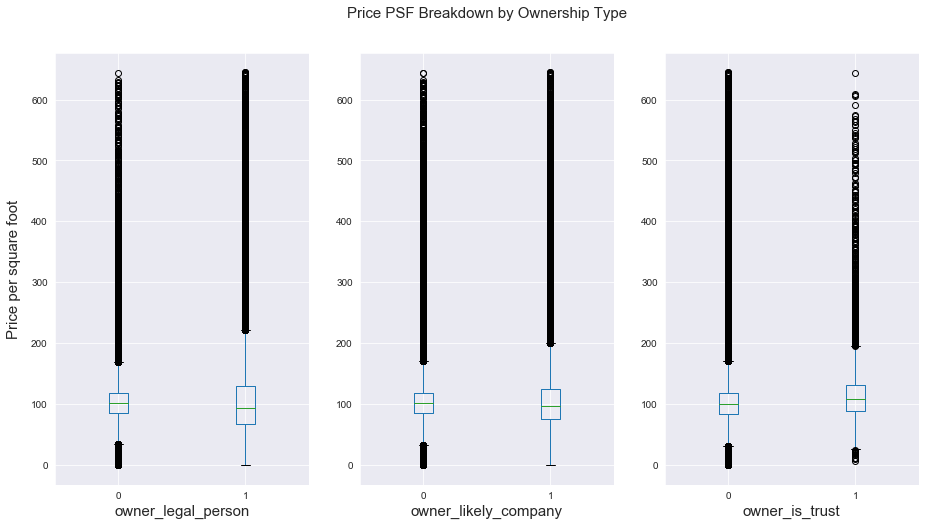

In [100]:
plot_price_by_owner(
    groups=groups,
    dataframe=trim_prop_df,
    title='Price PSF Breakdown by Ownership Type'
)

For cases where the owner is coded as either a legal person, "likely a company," or trust, the mean price per square foot is higher. However, the median price per square foot for the first two is lower than the median price where the owner is not a legal person or likely a company. This makes sense given the outliers visible in the boxplots.

In [101]:
groups = ['two_gto_reqs','foreign_based_owner']
group_stats(groups,trim_prop_df)

                  median        mean       min         max
two_gto_reqs                                              
0             100.614564  104.289317  0.019408  644.087838
1             120.622042  154.117108  1.815750  644.723389 

                        median        mean        min         max
foreign_based_owner                                              
0                    100.77576  105.833447   0.019408  644.723389
1                    106.61157  113.211512  22.692816  625.475343 



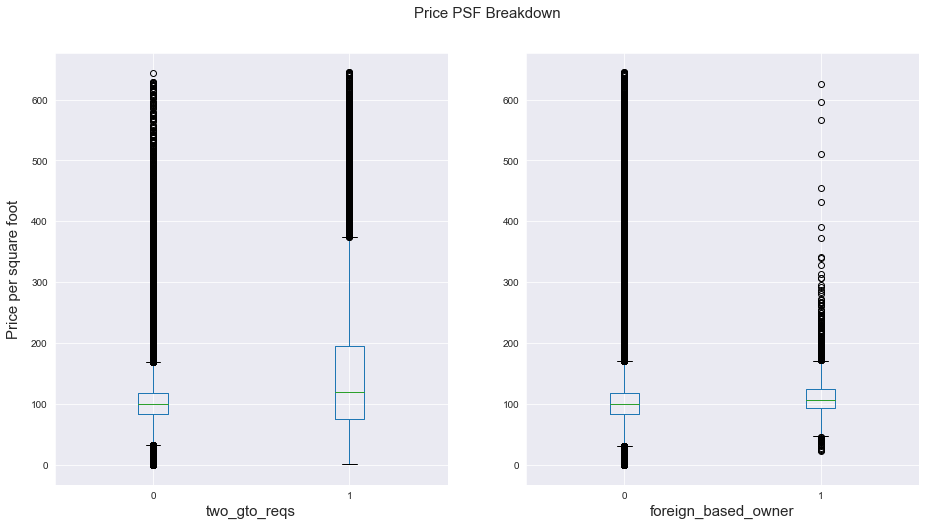

In [103]:
plot_price_by_owner(
    groups=groups,
    dataframe=trim_prop_df,
    title='Price PSF Breakdown'
)

A t-test will determine if the difference in mean price psf for the above binary variables is statistically significant.

In [104]:
print('Mean price psf for properties that meet the two GTO requirements:')
print(trim_prop_df[trim_prop_df.two_gto_reqs==1].price_psf.mean(),'\n')
print('Mean price psf for properties that do not meet the two GTO requirements:')
print(trim_prop_df[trim_prop_df.two_gto_reqs==0].price_psf.mean(),'\n')

Mean price psf for properties that meet the two GTO requirements:
154.11710761885925 

Mean price psf for properties that do not meet the two GTO requirements:
104.28931675100587 



In [39]:
print(stats.ttest_ind(trim_prop_df[trim_prop_df.two_gto_reqs==0].price_psf.dropna(),
                trim_prop_df[trim_prop_df.two_gto_reqs==1].price_psf.dropna()))

Ttest_indResult(statistic=-159.1633646536922, pvalue=0.0)


Given the p-value is returned as 0.0, it does appear the difference in mean price psf for properties that meet the price and ownership type components of FinCEN's GTO and those that do not is statistically significant.

In [40]:
print('Mean price psf for properties that meet the two GTO requirements:')
print(trim_prop_df[trim_prop_df.foreign_based_owner==1].price_psf.mean(),'\n')
print('Mean price psf for properties that do not meet the two GTO requirements:')
print(trim_prop_df[trim_prop_df.foreign_based_owner==0].price_psf.mean(),'\n')

Mean price psf for properties that meet the two GTO requirements:
113.2115118426925 

Mean price psf for properties that do not meet the two GTO requirements:
105.83344741901507 



In [41]:
stats.ttest_ind(trim_prop_df[trim_prop_df.foreign_based_owner==0].price_psf.dropna(),
                trim_prop_df[trim_prop_df.foreign_based_owner==1].price_psf.dropna())

Ttest_indResult(statistic=-10.07758577711993, pvalue=6.974031071800331e-24)

The p-value when comparing mean price psf for properties with a foreign-based owner and not would also indicate that the difference in the mean values is statistically significant.

In [109]:
def plot_price_hist(var,dataframe,subtitle_1,subtitle_2):
    fig, axes = plt.subplots(1,2,figsize=[15,5])
    dataframe[dataframe[var]==1].price_psf.dropna().plot(
        kind='hist',
        ax=axes[0],
        bins=50,
        log=True,
        color='lightcoral'
    )
    dataframe[dataframe[var]!=1].price_psf.dropna().plot(
        kind='hist',
        ax=axes[1],
        bins=50,
        log=True,
        color='royalblue'
    )
    axes[0].set_xlabel('Price per square foot',labelpad=10,fontsize=12)
    axes[0].set_ylabel('Frequency (log scale)',labelpad=10,fontsize=12)
    axes[0].set_title(subtitle_1,fontsize=15)    

    
    axes[1].set_xlabel('Price per square foot',labelpad=10,fontsize=12)
    axes[1].set_ylabel('Frequency (log scale)',labelpad=10,fontsize=12)
    axes[1].set_title(subtitle_2,fontsize=15)

    plt.show()

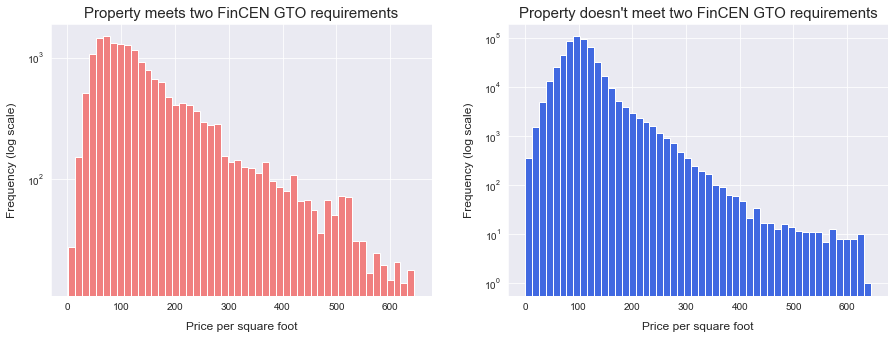

In [111]:
plot_price_hist(
    var = 'two_gto_reqs',
    dataframe=trim_prop_df,
    subtitle_1='Property meets two FinCEN GTO requirements',
    subtitle_2='Property doesn\'t meet two FinCEN GTO requirements'
)

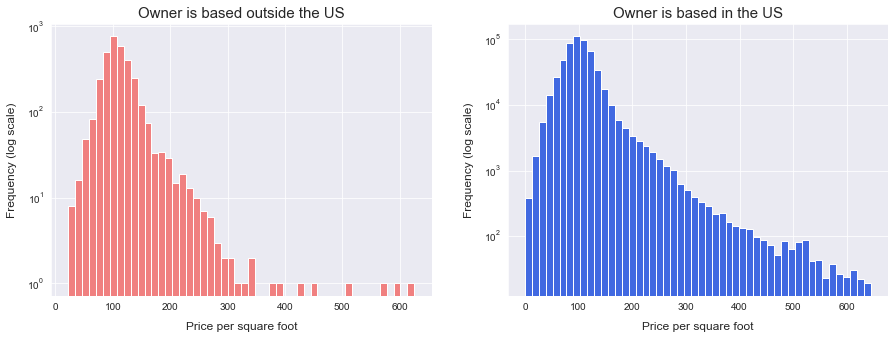

In [112]:
plot_price_hist(
    var='foreign_based_owner',
    dataframe=trim_prop_df,
    subtitle_1='Owner is based outside the US',
    subtitle_2='Owner is based in the US'
)

### Just-Established Owner and Owner Owns Multiple Properties
Does a just-established owner pay a higher price psf? What about an owner that owns multiple properties?

In [116]:
group_stats(groups=['just_established_owner','owner_owns_multiple'],
            dataframe=trim_prop_df)

                            median        mean       min         max
just_established_owner                                              
0                       100.861742  105.573697  0.019408  644.722689
1                        98.643151  120.955046  0.031926  644.723389 

                         median        mean       min         max
owner_owns_multiple                                              
0                    101.727079  106.411388  0.031926  644.723389
1                     92.413321  101.929043  0.019408  644.722689 



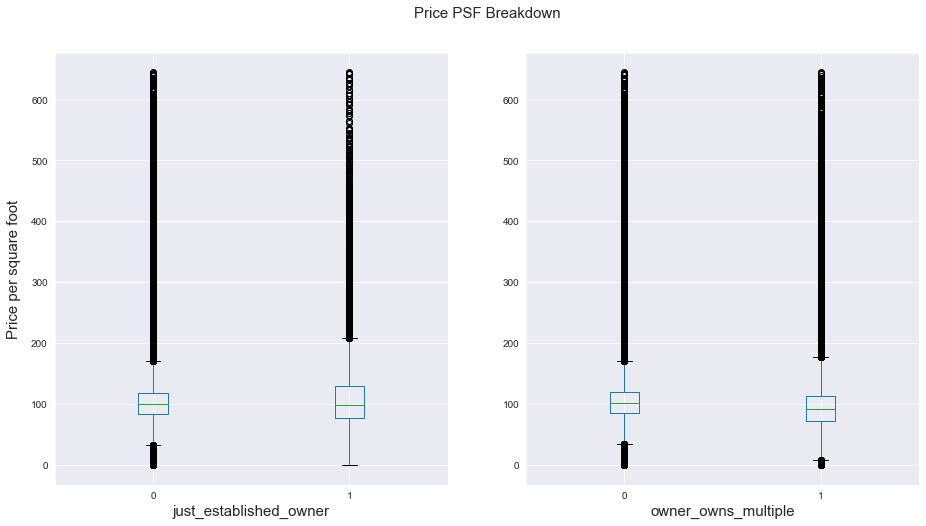

In [114]:
plot_price_by_owner(
    groups=['just_established_owner','owner_owns_multiple'],
    dataframe=trim_prop_df,
    title='Price PSF Breakdown'
)

While there are some outliers making the average higher, the median price per square foot for properties owned by companies established in the last 365 days is actually lower. It is a similar case for when the property owner owns multiple properties.

### Visualizing YoY Price Fluctuations

How do the fluctuations in price year-over-year differ between positively-labeled properties and the broader population?

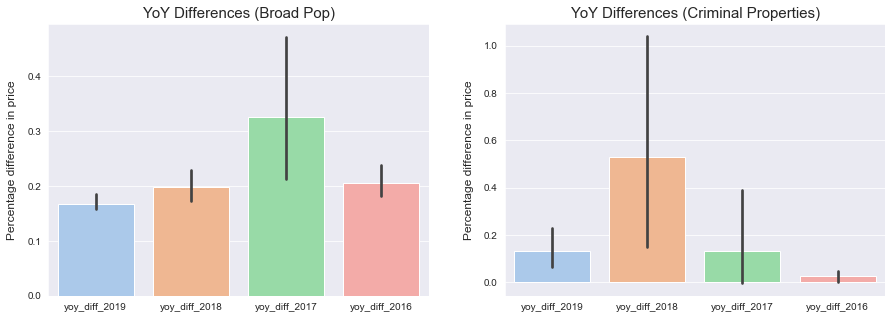

In [47]:
prop_melt = pd.melt(trim_prop_df[trim_prop_df.crim_prop!=1][['yoy_diff_2019','yoy_diff_2018','yoy_diff_2017','yoy_diff_2016']],var_name='year',value_name='yoy_diff').dropna()
crim_sub_melt = pd.melt(trim_prop_df[trim_prop_df.crim_prop==1][['yoy_diff_2019','yoy_diff_2018','yoy_diff_2017','yoy_diff_2016']],var_name='year',value_name='yoy_diff').dropna()

fig, axes = plt.subplots(1,2,figsize=[15,5])
sns.barplot(
    x='year',
    y='yoy_diff',
    data=prop_melt,
    palette='pastel',
    ax=axes[0]).set_title('YoY Differences (Broad Pop)',fontsize=15)
sns.barplot(
    x='year',
    y='yoy_diff',
    data=crim_sub_melt,
    palette='pastel',
    ax=axes[1]).set_title('YoY Differences (Criminal Properties)',fontsize=15)

axes[0].set_ylabel('Percentage difference in price',labelpad=10,fontsize=12)
axes[1].set_ylabel('Percentage difference in price',labelpad=10,fontsize=12)

axes[0].set_xlabel('')
axes[1].set_xlabel('')

plt.show()

### Missing Values

Identifying how many missing values there are per variable will allow meto to narrow down the list of variables that will be used in modeling.

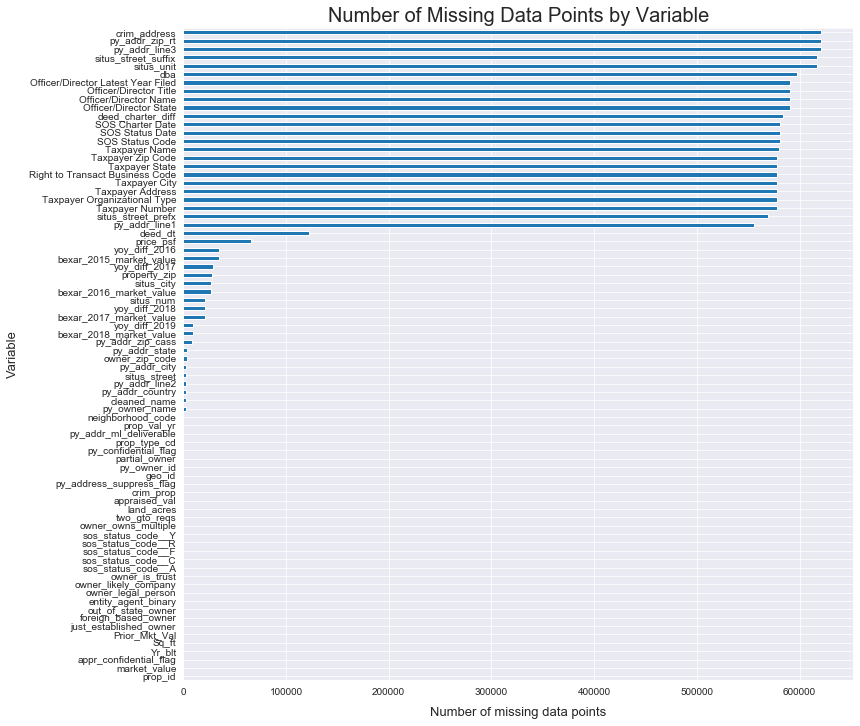

In [48]:
# How many missing values
ax = trim_prop_df.isnull().sum().sort_values().plot.barh(figsize = [12,12])
ax.set_title('Number of Missing Data Points by Variable',fontsize=20)
ax.set_xlabel('Number of missing data points',labelpad=10,fontsize=13)
ax.set_ylabel('Variable',labelpad=10,fontsize=13)
plt.show()

This is generally in line with what I was expecting. Most of the missing variables are from the companies data merge. Aside from owner_zip_code, the others will be dropped as features.

In [49]:
print('YoY Diff 2016 nulls:')
print(trim_prop_df.yoy_diff_2016.isnull().sum(),'\n')

YoY Diff 2016 nulls:
34947 



### Correlation Matrix

In [52]:
# Setting the number of acceptable NaN values to 70,000 to be sure to include Price PSF as a feature
nan_limit = 70000
check_nan = trim_prop_df.isnull().sum()

variables_list = check_nan[check_nan<nan_limit].index
variables_list = variables_list[variables_list.isin(trim_prop_df.columns[trim_prop_df.dtypes!='object'])]
variables_list = variables_list.drop(['prop_id','py_owner_id','py_addr_zip_cass','prop_val_yr','appraised_val',
                                     'Prior_Mkt_Val','bexar_2015_market_value','bexar_2016_market_value', 
                                      'bexar_2017_market_value','bexar_2018_market_value'])

# Pull out variables and plot correlation matrix
sub_df = trim_prop_df[variables_list]

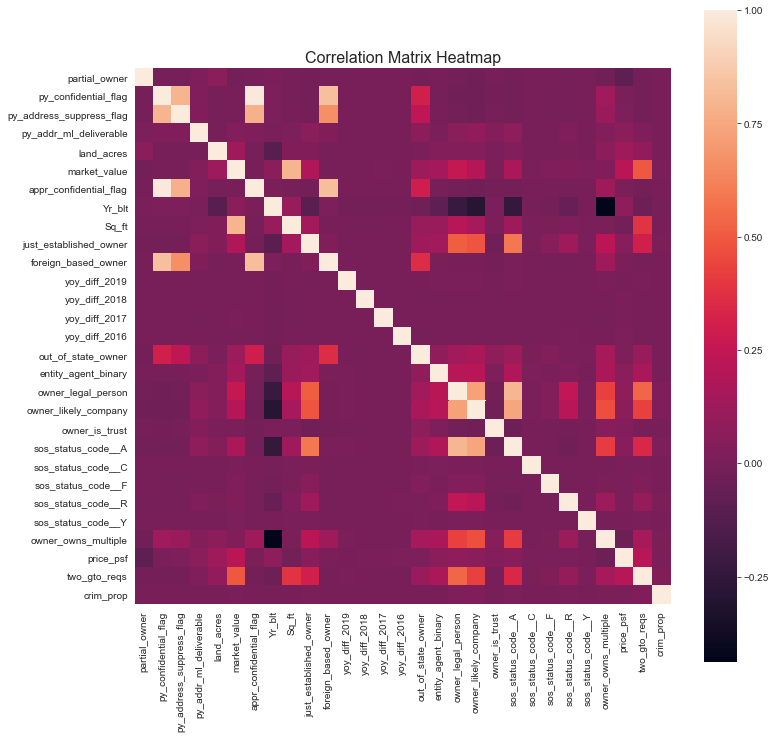

In [117]:
plt.figure(figsize=(12,12))
plt.title('Correlation Matrix Heatmap',fontsize=16)
sns.heatmap(sub_df.corr(),vmax=1,square=True)
plt.show()

### Observations:
- High correlation amongst the "confidential flag" variables, which makes sense. 
- High correlation between market value and square footage, which is expected.
- Does not seem to be much correlation between the criminal property label and the other variables